In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score,confusion_matrix,classification_report
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

## First we are going to load the training data

### Loading the data from BQ.

To use this method you have to load this data previously to BigQuery. To upload the data to BQ you can follow the next [tutorial](https://cloud.google.com/bigquery/docs/loading-data-cloud-storage-csv#console)

Data can be found [here](https://www.kaggle.com/datasets/ealaxi/paysim1)

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

In [ ]:
%%bigquery df --project <project_id>
SELECT 
  *
FROM `<project_id>.<dataset>.<table>`

### Loading the data from local csv file.

Data can be found [here](https://www.kaggle.com/datasets/ealaxi/paysim1)

After downloading the data you have to upload it to google colab

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
df = pd.read_csv('<data_file>.csv')

Now we can review the DF

In [ ]:
df

Transform type column to dummy variables

In [2]:
df = pd.get_dummies(df, columns=['type'])

We will drop label category as well as the ones that only contain naming

In [3]:
Y = df['isFraud']
X = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud',"isFraud"], axis = 1)
X.columns

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')

Here are some transactions that has been marked as fraud

In [4]:
df[df['isFraud'] == 1].head(10)

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
2,1,181.00,C1305486145,181.00,0.0,C553264065,0.0,0.00,1,0,False,False,False,False,True
3,1,181.00,C840083671,181.00,0.0,C38997010,21182.0,0.00,1,0,False,True,False,False,False
251,1,2806.00,C1420196421,2806.00,0.0,C972765878,0.0,0.00,1,0,False,False,False,False,True
252,1,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.0,0.00,1,0,False,True,False,False,False
680,1,20128.00,C137533655,20128.00,0.0,C1848415041,0.0,0.00,1,0,False,False,False,False,True
681,1,20128.00,C1118430673,20128.00,0.0,C339924917,6268.0,12145.85,1,0,False,True,False,False,False
724,1,416001.33,C749981943,0.00,0.0,C667346055,102.0,9291619.62,1,0,False,True,False,False,False
969,1,1277212.77,C1334405552,1277212.77,0.0,C431687661,0.0,0.00,1,0,False,False,False,False,True
970,1,1277212.77,C467632528,1277212.77,0.0,C716083600,0.0,2444985.19,1,0,False,True,False,False,False
1115,1,35063.63,C1364127192,35063.63,0.0,C1136419747,0.0,0.00,1,0,False,False,False,False,True


Split the data for training

In [5]:
randomState = 5
np.random.seed(randomState)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = randomState)

In [6]:
# Long computation in this cell (~1.8 minutes)
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              probabilities[:, 1])))

AUPRC = 0.9303687648692213


We analyze the importance of the features in the model.

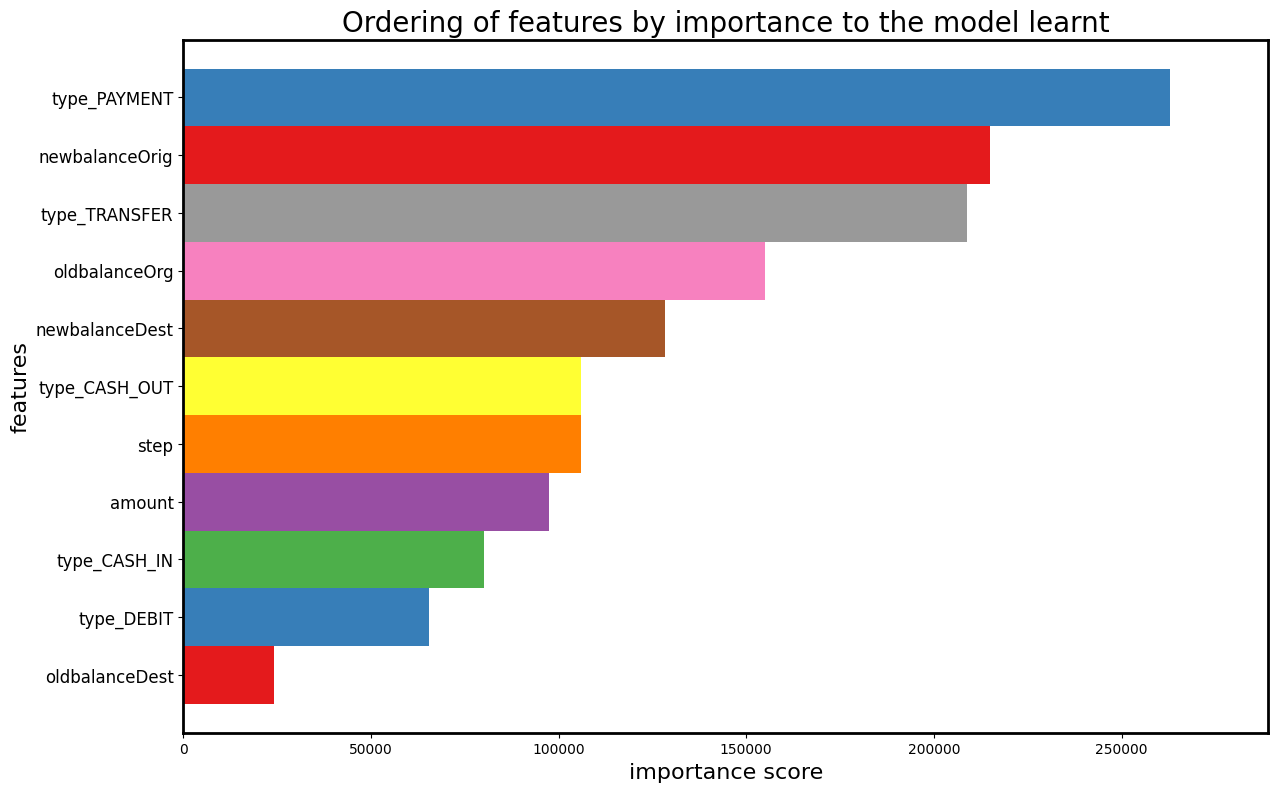

In [7]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

This is a representation of the model

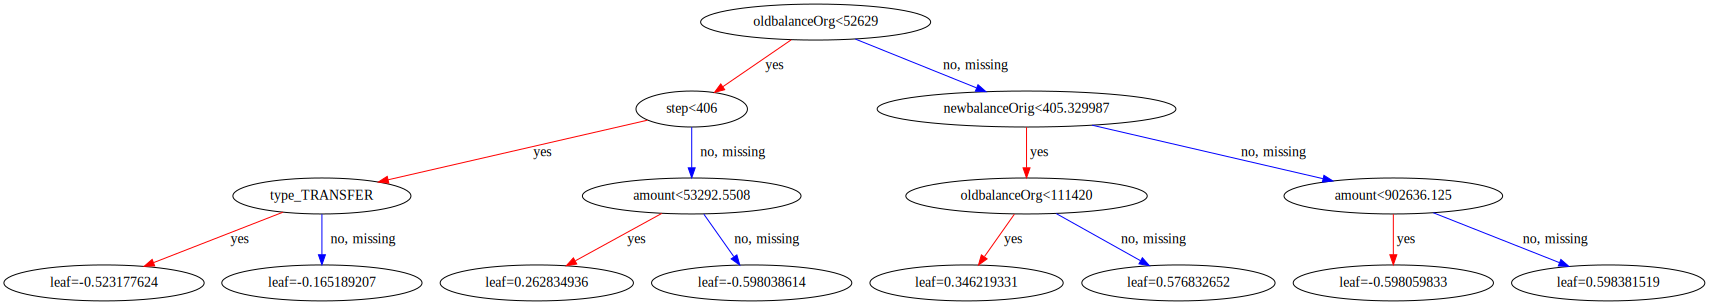

In [8]:
to_graphviz(clf)

Test the model only for the fraud transactions

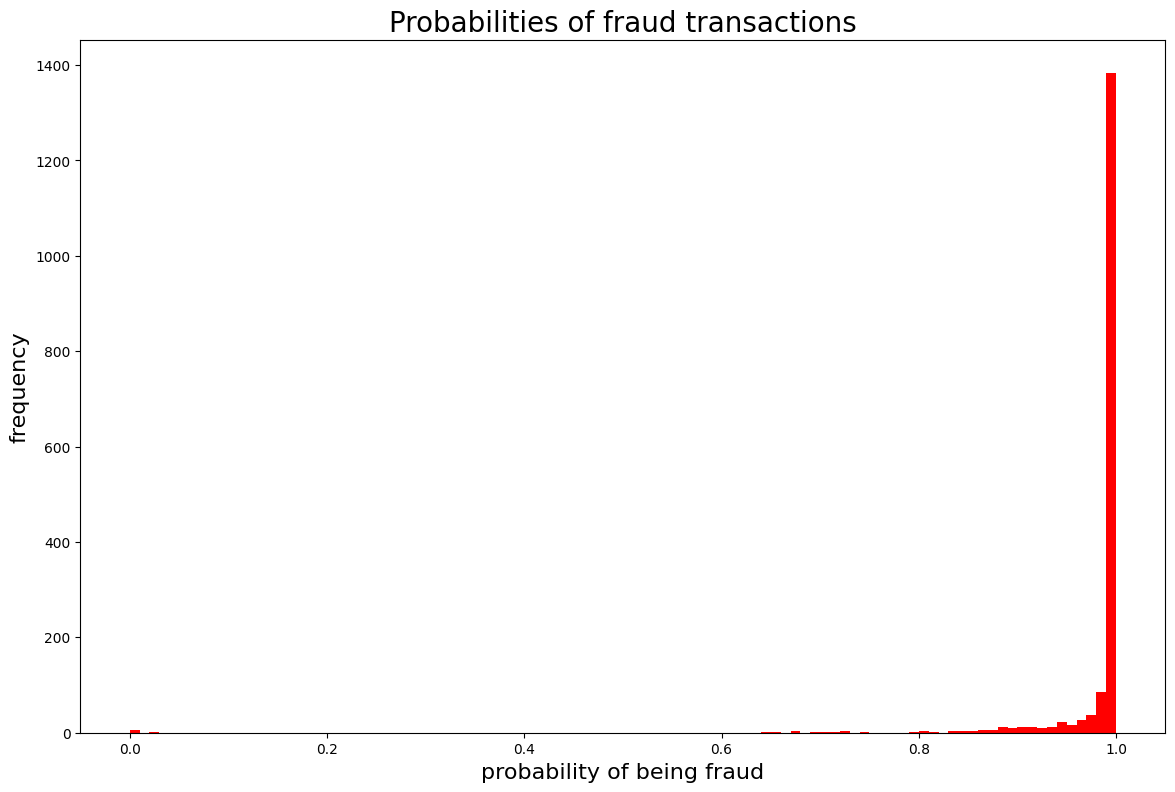

In [9]:
testX_2 = testX[testY == 1]
testY_2 = testY[testY == 1]
probabilities = clf.predict_proba(testX_2)
# plot probabilities
probabilities = clf.predict_proba(testX_2)
plt.figure(figsize = (14, 9))
plt.hist(probabilities[:, 1], bins = 100, color = 'r')
plt.xlabel('probability of being fraud', size = 16)
plt.ylabel('frequency', size = 16)
plt.title('Probabilities of fraud transactions', size = 20);
plt.show()

Test the model only for the legit transactions

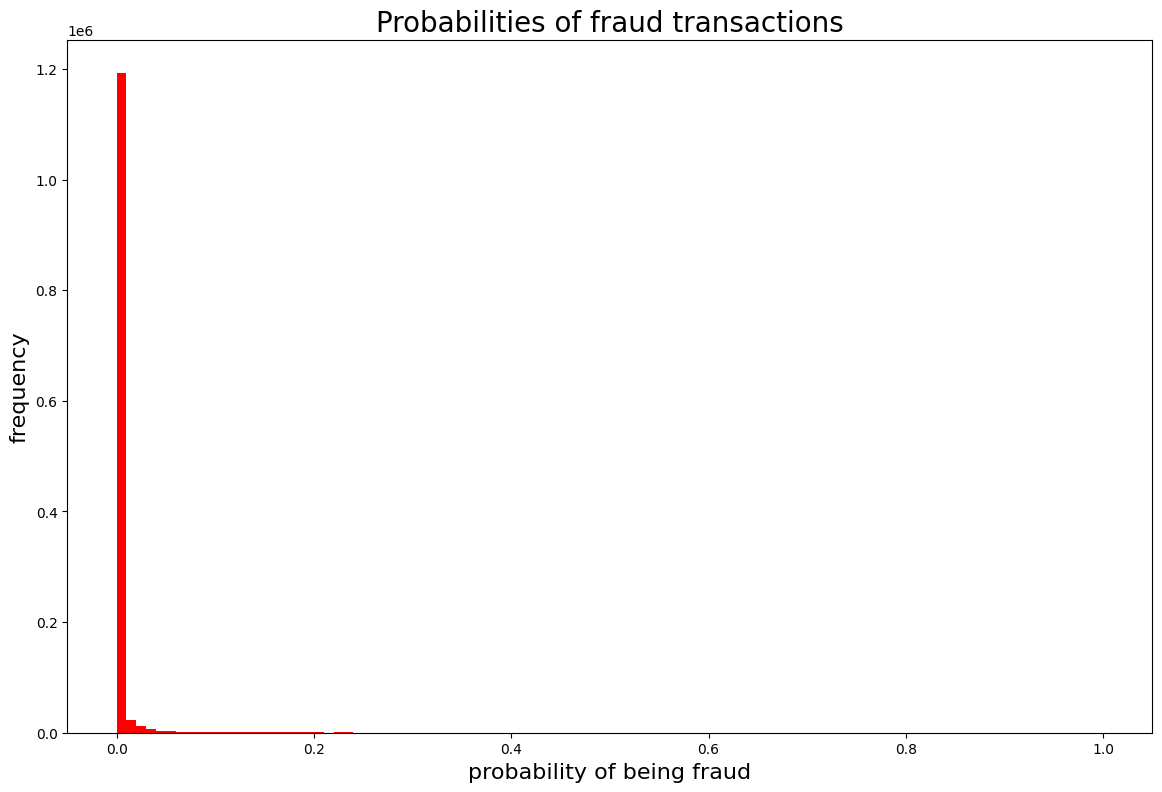

In [10]:
testX_2 = testX[testY == 0]
testY_2 = testY[testY == 0]
probabilities = clf.predict_proba(testX_2)
# plot probabilities
probabilities = clf.predict_proba(testX_2)
plt.figure(figsize = (14, 9))
plt.hist(probabilities[:, 1], bins = 100, color = 'r')
plt.xlabel('probability of being fraud', size = 16)
plt.ylabel('frequency', size = 16)
plt.title('Probabilities of fraud transactions', size = 20);
plt.show()

Now we will take a look at the confusion Matrix

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


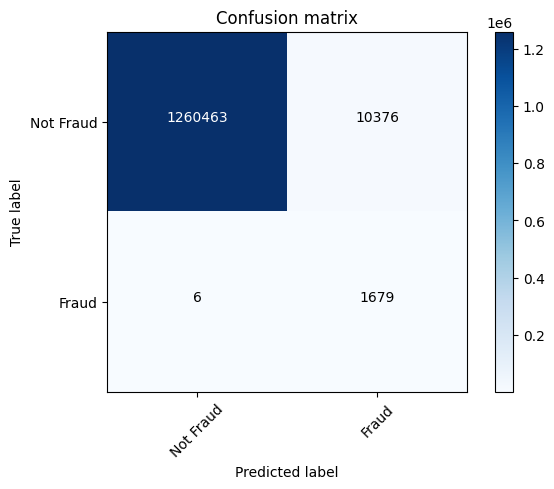

In [12]:

y_pred = clf.predict(testX)
cm = confusion_matrix(testY, y_pred)
plot_confusion_matrix(cm, classes=['Not Fraud','Fraud'])

| | |
|-|-|
|TP|FP|
|FN|TN|

TP = True Positives

FP = False Positive

FN = False Negative

TN = True Negative


Precision = Tp/ (Tp + Fp)

Recall = TP / (TP+ FN)

F1-score = TP/(TP+1/2(FP+FN))

Accuracy = (TP+TN)/(TP+TN+FP+FN)

In [13]:
#Classification metrics
print(classification_report(testY, y_pred, target_names=['Not Fraud','Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      0.99      1.00   1270839
       Fraud       0.14      1.00      0.24      1685

    accuracy                           0.99   1272524
   macro avg       0.57      0.99      0.62   1272524
weighted avg       1.00      0.99      0.99   1272524



And we can save the model for uploading it to the cloud

In [ ]:
clf.save_model('model.bst')